# Hyper-paramter optimization experiments

> API details.

In [23]:
#hide
from nbdev.showdoc import *

In [24]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core

numpy.random.seed(42)

In [25]:
# export

from joblib import load, dump
import optuna

# Inspect hyper-param study

In [26]:
def load_studies(study_name, db_path, test_score_path):
    
    test_scores = load(test_score_path)
    
    data = []
    trial_data = []
    for i in range(3):
        for j in range(3):
            study = optuna.load_study(study_name % (i, j), storage=f"sqlite:////{db_path}")

            filtered_study = optuna.study.create_study(study_name=study.study_name)
            for trial in study.get_trials():
                if not ((trial.value is None) or (trial.value > 1)):
                    filtered_study.add_trial(trial)
                    
                    trial_data.append({
                        "outer": i, "repeat": j, "value": trial.value
                    })

            tmp = {
                "best_value": study.best_value, "test_score": test_scores[i][j],
                "outer": i, "repeat": j, "n_trials": len(filtered_study.trials), "study": filtered_study
            }

            tmp.update(study.best_params)

            data.append(tmp)
    
    return pandas.DataFrame(data), pandas.DataFrame(trial_data)

In [ ]:
results1, trials1 = load_studies(
    "tmr_run1_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_sgdmlp.sqlite",
    "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_sgdmlp.dat"
)

In [27]:
results2, trials2 = load_studies(
    "tmr_xgb_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_xgb.sqlite",
    "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_xgb.dat"
)

<ipython-input-26-98ab945d4e76>:14: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.



## Performance

Text(0.5, 1.0, 'validation score')

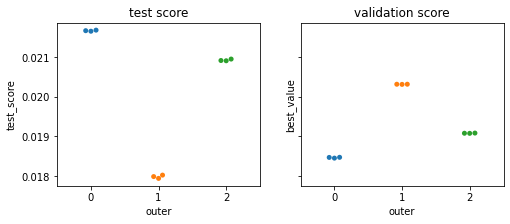

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
seaborn.swarmplot("outer", "test_score", data=results2, ax=ax[0])
ax[0].set_title("test score")
seaborn.swarmplot("outer", "best_value", data=results2, ax=ax[1])
ax[1].set_title("validation score")

In [29]:
results2

,best_value,test_score,outer,repeat,n_trials,study,learning_rate,max_depth,model_name,n_estimators,subsample
0,0.018473,0.021679,0,0,501,<optuna.study.Study object at 0x7f2dc9988a60>,0.033676,8,xgb,389,0.680300
1,0.018455,0.021665,0,1,501,<optuna.study.Study object at 0x7f2dc8cbcfd0>,0.033752,8,xgb,394,0.693251
2,0.018476,0.021651,0,2,500,<optuna.study.Study object at 0x7f2dca303c40>,0.036863,8,xgb,393,0.689914
3,0.020312,0.018028,1,0,500,<optuna.study.Study object at 0x7f2dc8a86820>,0.033080,8,xgb,400,0.691157
4,0.020317,0.017990,1,1,500,<optuna.study.Study object at 0x7f2dc88de400>,0.027225,9,xgb,394,0.749499
5,0.020316,0.017945,1,2,500,<optuna.study.Study object at 0x7f2dc8793460>,0.029014,9,xgb,383,0.554804
6,0.019079,0.020914,2,0,500,<optuna.study.Study object at 0x7f2dc88c5850>,0.024992,9,xgb,381,0.709213
7,0.019082,0.020907,2,1,500,<optuna.study.Study object at 0x7f2dc88c52e0>,0.030021,9,xgb,400,0.917520
8,0.019086,0.020950,2,2,500,<optuna.study.Study object at 0x7f2dc8333bb0>,0.026831,9,xgb,393,0.757351


## Studies

### XGB

We use the slice plot to inspect the convergence of a hyper-parameter study.

In [ ]:
optuna.visualization.plot_slice(results2.loc[0, "study"], params=["learning_rate", "max_depth", "n_estimators", "subsample"])

In [ ]:
optuna.visualization.plot_slice(results2.loc[3, "study"], params=["learning_rate", "max_depth", "n_estimators", "subsample"])

We use the contour plot to inspect the cost landscape in a study. It also nicely shows convergence.

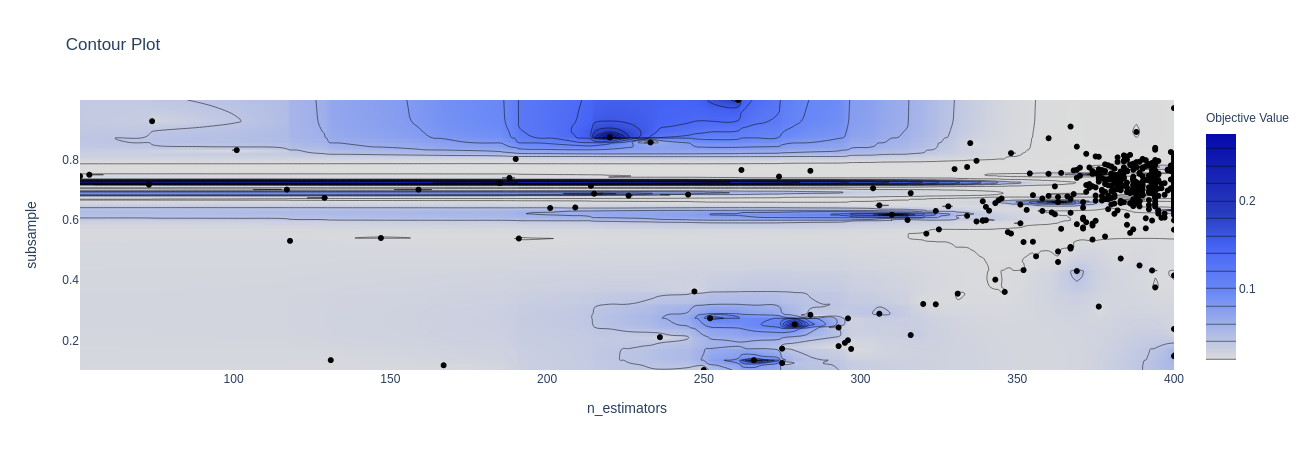

In [30]:
optuna.visualization.plot_contour(results2.loc[0, "study"], params=["n_estimators", "subsample"])

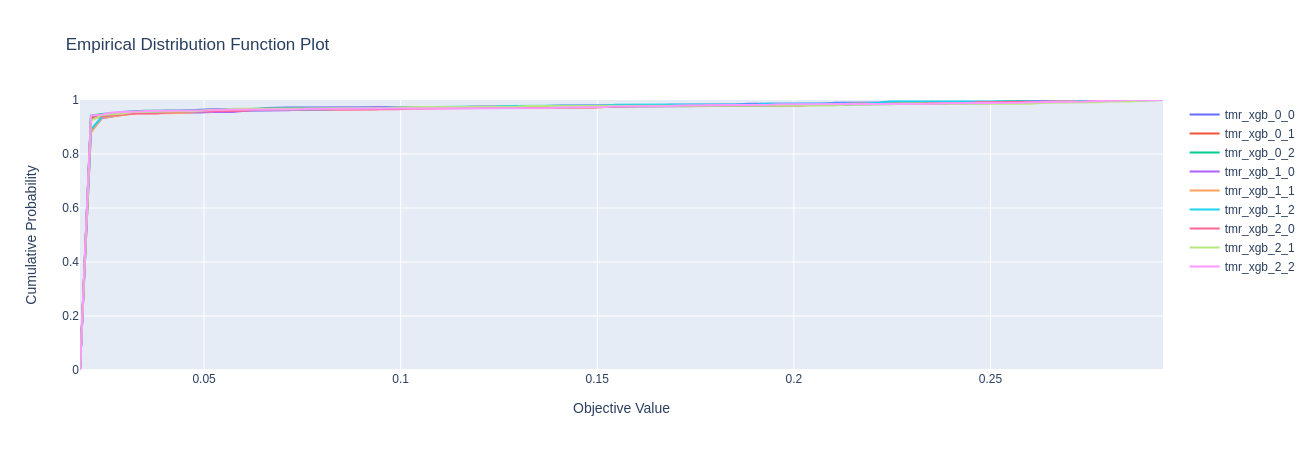

In [32]:
optuna.visualization.plot_edf(results2["study"])

### MLP

In [ ]:
results1["avg_hidden_nodes_per_layer"] = results1.filter(regex="hidden_layer_size_.*").sum(axis=1) / results1["n_layers"]

In [ ]:
results["avg_hidden_nodes_per_layer"].plot.bar()

In [ ]:
optuna.visualization.plot_contour(studies[0], params=["learning_rate_init", "n_layers"])

In [ ]:
optuna.visualization.plot_slice(studies[0], params=["eta0", "alpha", "learning_rate", "loss", "n_layers", "activation", "model_name"])